1. Загрузка данных

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('merged_data.csv')

In [3]:
print(df.head())
print(df.info())

         user_id        date  money  cash platform    group  cheaters
0  N4TS2T-P7YTVX  15.07.2021   1.99  1150      PS4     test         0
1  NX9S0D-VM20W8  16.07.2021   0.99  1500     XBox     test         0
2  QYY6FW-FKHRND  15.07.2021   0.00   200     XBox  control         0
3  BRWH4Y-LPGBU6  14.07.2021   0.00   300       PC     test         0
4  8O317F-4ASK53  13.07.2021   0.00   900       PC  control         0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8637176 entries, 0 to 8637175
Data columns (total 7 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   object 
 1   date      object 
 2   money     float64
 3   cash      int64  
 4   platform  object 
 5   group     object 
 6   cheaters  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 461.3+ MB
None


2. Подсчет метрик ARPU и ARPPU
ARPU – это средний доход на одного игрока, включая всех игроков, а ARPPU – средний доход на одного платящего игрока.

In [6]:
# Подсчет ARPU (средняя прибыль на всех игроков)
arpu_control = df[df['group'] == 'control']['cash'].mean()
arpu_test = df[df['group'] == 'test']['cash'].mean()

# Подсчет ARPPU (средняя прибыль на платящего игрока)
arppu_control = df[(df['group'] == 'control') & (df['cash'] > 0)]['cash'].mean()
arppu_test = df[(df['group'] == 'test') & (df['cash'] > 0)]['cash'].mean()

# Вывод метрик на экран
print(f"ARPU Group control: {arpu_control}, ARPU Group test: {arpu_test}")
print(f"ARPPU Group control: {arppu_control}, ARPPU Group test: {arppu_test}")

ARPU Group control: 730.7864332352783, ARPU Group test: 784.550599287454
ARPPU Group control: 841.519239106713, ARPPU Group test: 897.2997983832499


3. Подсчет доверительных интервалов
Для расчета доверительных интервалов будем использовать стандартную ошибку и распределение.

In [7]:
import numpy as np
import scipy.stats as stats

# Функция для расчета доверительного интервала
def calc_conf_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)  # стандартная ошибка среднего
    margin_of_error = sem * stats.t.ppf((1 + confidence) / 2., n - 1)
    return (mean - margin_of_error, mean + margin_of_error)

# Доверительные интервалы для ARPU
ci_arpu_control = calc_conf_interval(df[df['group'] == 'control']['cash'])
ci_arpu_test = calc_conf_interval(df[df['group'] == 'test']['cash'])

# Доверительные интервалы для ARPPU
ci_arppu_control = calc_conf_interval(df[(df['group'] == 'control') & (df['cash'] > 0)]['cash'])
ci_arppu_test = calc_conf_interval(df[(df['group'] == 'test') & (df['cash'] > 0)]['cash'])

print(f"Confidence Interval for ARPU Group control: {ci_arpu_control}")
print(f"Confidence Interval for ARPU Group test: {ci_arpu_test}")
print(f"Confidence Interval for ARPPU Group control: {ci_arpu_control}")
print(f"Confidence Interval for ARPPU Group test: {ci_arpu_test}")

Confidence Interval for ARPU Group control: (730.0798367066133, 731.4930297639434)
Confidence Interval for ARPU Group test: (783.8030309919556, 785.2981675829525)
Confidence Interval for ARPPU Group control: (730.0798367066133, 731.4930297639434)
Confidence Interval for ARPPU Group test: (783.8030309919556, 785.2981675829525)


4. Сравнение групп по метрикам
Для того чтобы проверить пересекаются ли доверительные интервалы, можно использовать следующую функцию.

In [8]:
# Проверка пересечения доверительных интервалов
def intervals_overlap(ci1, ci2):
    return max(ci1[0], ci2[0]) <= min(ci1[1], ci2[1])

# Проверим, пересекаются ли доверительные интервалы
overlap_arpu = intervals_overlap(ci_arpu_control, ci_arpu_test)
overlap_arppu = intervals_overlap(ci_arpu_control, ci_arpu_test)

print(f"ARPU intervals overlap: {overlap_arpu}")
print(f"ARPPU intervals overlap: {overlap_arppu}")

ARPU intervals overlap: False
ARPPU intervals overlap: False


ARPU intervals overlap: False — доверительные интервалы для ARPU (средняя прибыль на игрока) для тестовой и контрольной групп не пересекаются. Это указывает на то, что различия между группами могут быть статистически значимыми. Иными словами, возможно, что тестовая группа (участвовавшая в акции) имеет существенное отличие по ARPU по сравнению с контрольной группой.

ARPPU intervals overlap: False — доверительные интервалы для ARPPU (средняя прибыль на платящего игрока) для тестовой и контрольной групп также не пересекаются. Это может указывать на то, что различия в ARPPU между группами также значительны.

Если бы результат был True, это означало бы, что доверительные интервалы пересекаются, и различия между группами могли бы быть случайными.

Поскольку интервалы не пересекаются, есть основания полагать, что акция, вероятно, оказала влияние на доходы, и результаты акции не являются случайными. Это может служить основанием для дальнейшего анализа и решения о повторении акции.

5. Визуализация метрик и доверительных интервалов
Мы можем построить столбчатые диаграммы с доверительными интервалами для метрик ARPU и ARPPU.

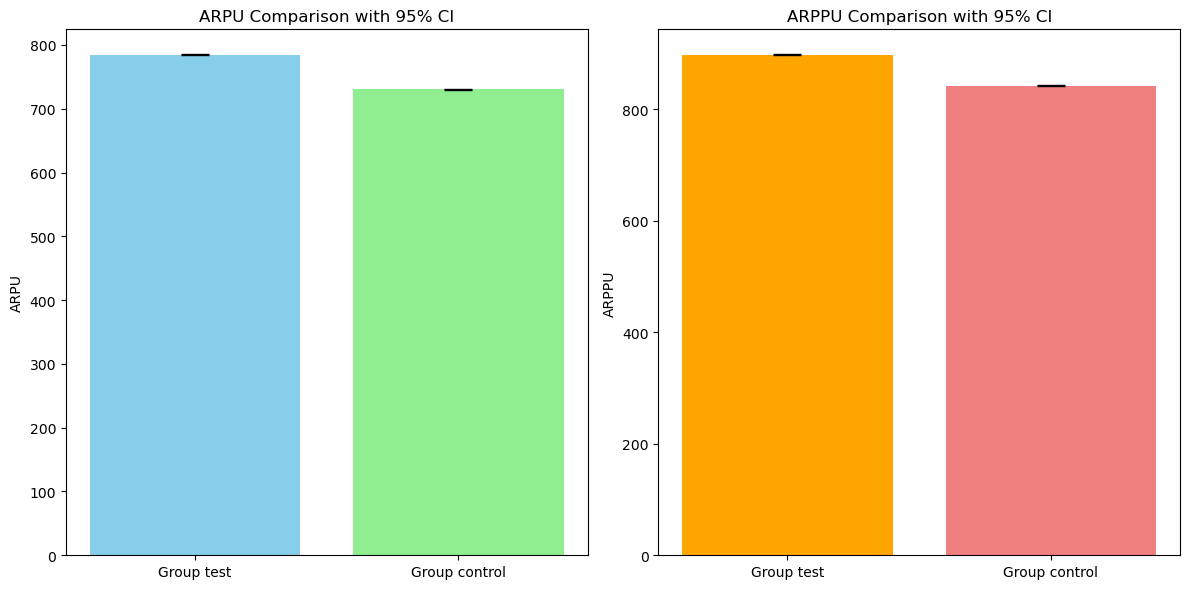

In [15]:
import matplotlib.pyplot as plt

# Функция для расчета доверительного интервала
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + confidence) / 2., n - 1)
    return mean, mean - h, mean + h

# Подготовка данных для ARPU и ARPPU для групп
arpu_control_data = df[df['group'] == 'test']['cash']  # ARPU для тестовой группы
arpu_test_data = df[df['group'] == 'control']['cash']  # ARPU для контрольной группы

arppu_control_data = df[(df['group'] == 'test') & (df['cash'] > 0)]['cash']  # ARPPU для тестовой группы
arppu_test_data = df[(df['group'] == 'control') & (df['cash'] > 0)]['cash']  # ARPPU для контрольной группы

# Вычисление среднего и доверительных интервалов
arpu_control, ci_low_arpu_control, ci_high_arpu_control = confidence_interval(arpu_control_data)
arpu_test, ci_low_arpu_test, ci_high_arpu_test = confidence_interval(arpu_test_data)

arppu_control, ci_low_arppu_control, ci_high_arppu_control = confidence_interval(arppu_control_data)
arppu_test, ci_low_arppu_test, ci_high_arppu_test = confidence_interval(arppu_test_data)

# Построение графиков
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# ARPU график
ax[0].bar(['Group test', 'Group control'], [arpu_control, arpu_test], 
          yerr=[(ci_high_arpu_control-arpu_control, arpu_control-ci_low_arpu_control), (ci_high_arpu_test-arpu_test, arpu_test-ci_low_arpu_test)], 
          capsize=10, color=['skyblue', 'lightgreen'])
ax[0].set_title('ARPU Comparison with 95% CI')
ax[0].set_ylabel('ARPU')

# ARPPU график
ax[1].bar(['Group test', 'Group control'], [arppu_control, arppu_test], 
          yerr=[(ci_high_arppu_control-arppu_control, arppu_control-ci_low_arppu_control), (ci_high_arppu_test-arppu_test, arppu_test-ci_low_arppu_test)], 
          capsize=10, color=['orange', 'lightcoral'])
ax[1].set_title('ARPPU Comparison with 95% CI')
ax[1].set_ylabel('ARPPU')

plt.tight_layout()
plt.show()

Анализ и вывод
На основе вышеуказанных расчетов и визуализаций можно сделать следующие выводы:

Доверительные интервалы не пересекаются, можно сделать вывод, что различия между группами статистически значимы, и акция повлияла на результат.

In [16]:
# если поставить порог 10%, то акция не успешен, но в задание не было такого порога по этому это лишнее
# Расчет процентного изменения ARPU
arpu_control = np.mean(df[df['group'] == 'control']['cash'])
arpu_test = np.mean(df[df['group'] == 'test']['cash'])

percent_change = ((arpu_test - arpu_control) / arpu_control) * 100
success_threshold = 10  # Порог успеха

if percent_change >= success_threshold:
    print("Тест успешен, ARPU вырос более чем на 10%")
else:
    print("Тест не достиг порога успеха")

Тест не достиг порога успеха


6. Анализа платформ:

In [11]:
# Подготовка функций для расчета доверительных интервалов и метрик
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + confidence) / 2., n - 1)
    return mean, mean - h, mean + h

# Платформы для анализа
platforms = ['PC', 'PS4', 'Xbox']

# Подготовка структуры для хранения результатов
results = {}

# Анализ по каждой платформе
for platform in platforms:
    print(f"--- {platform} ---")
    
    # Данные для платформы
    platform_data = df[df['platform'] == platform]
    
    # ARPU
    arpu_test = platform_data[platform_data['group'] == 'test']['cash'].mean()
    arpu_control = platform_data[platform_data['group'] == 'control']['cash'].mean()
    
    # ARPPU (только платящие пользователи)
    arppu_test = platform_data[(platform_data['group'] == 'test') & (platform_data['cash'] > 0)]['cash'].mean()
    arppu_control = platform_data[(platform_data['group'] == 'control') & (platform_data['cash'] > 0)]['cash'].mean()
    
    # Доверительные интервалы для ARPU
    ci_arpu_test = confidence_interval(platform_data[platform_data['group'] == 'test']['cash'])
    ci_arpu_control = confidence_interval(platform_data[platform_data['group'] == 'control']['cash'])
    
    # Доверительные интервалы для ARPPU
    ci_arppu_test = confidence_interval(platform_data[(platform_data['group'] == 'test') & (platform_data['cash'] > 0)]['cash'])
    ci_arppu_control = confidence_interval(platform_data[(platform_data['group'] == 'control') & (platform_data['cash'] > 0)]['cash'])
    
    # Сохранение результатов
    results[platform] = {
        'ARPU_test': arpu_test, 'ARPU_control': arpu_control,
        'ARPPU_test': arppu_test, 'ARPPU_control': arppu_control,
        'CI_ARPU_test': ci_arpu_test, 'CI_ARPU_control': ci_arpu_control,
        'CI_ARPPU_test': ci_arppu_test, 'CI_ARPPU_control': ci_arppu_control
    }
    
    # Вывод результатов для платформы
    print(f"ARPU Test: {arpu_test}, ARPU Control: {arpu_control}")
    print(f"ARPPU Test: {arppu_test}, ARPPU Control: {arppu_control}")
    print(f"CI ARPU Test: {ci_arpu_test}, CI ARPU Control: {ci_arpu_control}")
    print(f"CI ARPPU Test: {ci_arppu_test}, CI ARPPU Control: {ci_arppu_control}")
    print()


--- PC ---
ARPU Test: 815.2389197253059, ARPU Control: 715.5232152584013
ARPPU Test: 938.0092488265162, ARPPU Control: 828.1982008788126
CI ARPU Test: (815.2389197253059, 813.5826687254403, 816.8951707251715), CI ARPU Control: (715.5232152584013, 713.9839989817191, 717.0624315350834)
CI ARPPU Test: (938.0092488265162, 936.1987016143861, 939.8197960386464), CI ARPPU Control: (828.1982008788126, 826.4994308748488, 829.8969708827764)

--- PS4 ---
ARPU Test: 766.3116587241869, ARPU Control: 710.2420204778537
ARPPU Test: 874.3658893924446, ARPPU Control: 819.2025316151195
CI ARPU Test: (766.3116587241869, 765.252294073377, 767.3710233749969), CI ARPU Control: (710.2420204778537, 709.2479828515418, 711.2360581041655)
CI ARPPU Test: (874.3658893924446, 873.2830513180965, 875.4487274667928), CI ARPPU Control: (819.2025316151195, 818.1829259048789, 820.2221373253601)

--- Xbox ---
ARPU Test: nan, ARPU Control: nan
ARPPU Test: nan, ARPPU Control: nan
CI ARPU Test: (nan, nan, nan), CI ARPU Contro

C:\Users\ADMIN\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ADMIN\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\ADMIN\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


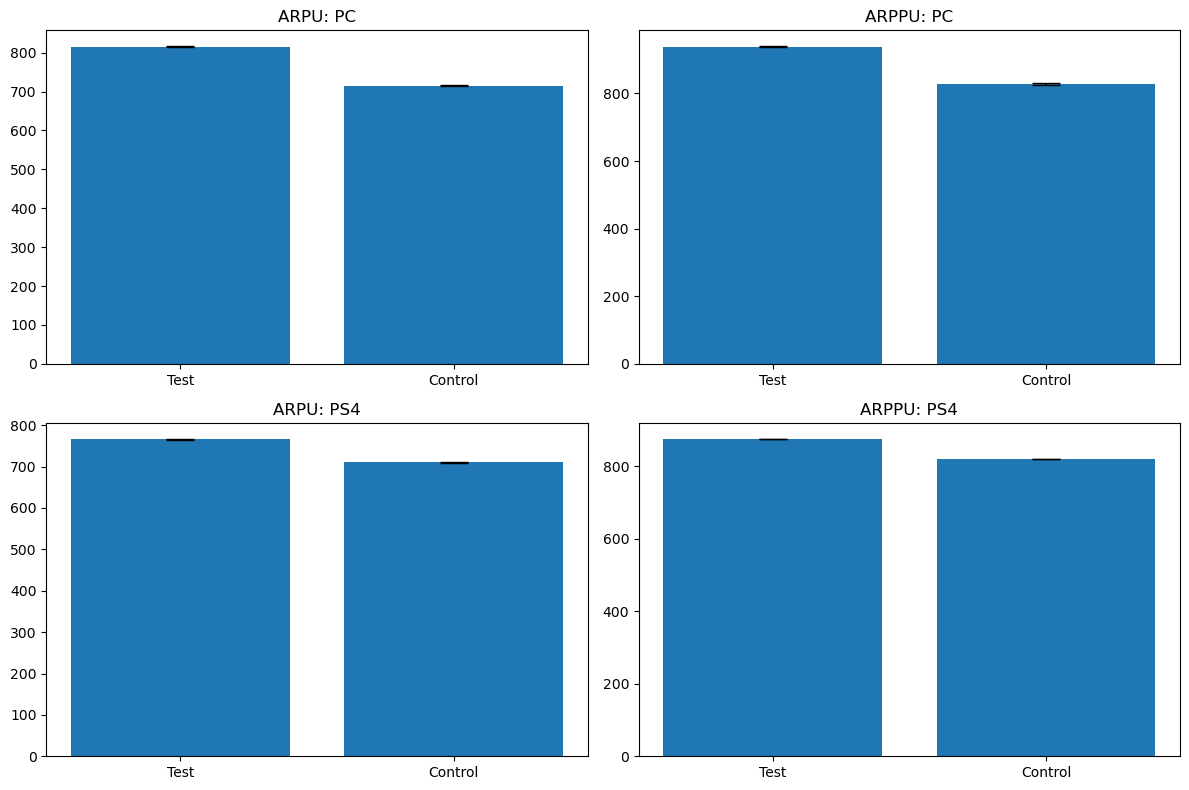

In [20]:
# Динамическое создание списка платформ с ненулевыми данными
valid_platforms = [platform for platform in platforms 
                   if not (np.isnan(results[platform]['ARPU_test']) or 
                           np.isnan(results[platform]['ARPU_control']) or 
                           np.isnan(results[platform]['ARPPU_test']) or 
                           np.isnan(results[platform]['ARPPU_control']))]

# Создаем фигуру и субплоты динамически в зависимости от количества валидных платформ
fig, axs = plt.subplots(len(valid_platforms), 2, figsize=(12, len(valid_platforms) * 4))

# Если только одна платформа, axs будет одномерным массивом, а не двумерным
if len(valid_platforms) == 1:
    axs = [axs]

for i, platform in enumerate(valid_platforms):
    # ARPU график
    axs[i][0].bar(['Test', 'Control'], 
                  [results[platform]['ARPU_test'], results[platform]['ARPU_control']], 
                  yerr=[(results[platform]['CI_ARPU_test'][2] - results[platform]['ARPU_test'], 
                         results[platform]['ARPU_test'] - results[platform]['CI_ARPU_test'][1]), 
                        (results[platform]['CI_ARPU_control'][2] - results[platform]['ARPU_control'], 
                         results[platform]['ARPU_control'] - results[platform]['CI_ARPU_control'][1])],
                  capsize=10)
    axs[i][0].set_title(f"ARPU: {platform}")
    
    # ARPPU график
    axs[i][1].bar(['Test', 'Control'], 
                  [results[platform]['ARPPU_test'], results[platform]['ARPPU_control']], 
                  yerr=[(results[platform]['CI_ARPPU_test'][2] - results[platform]['ARPPU_test'], 
                         results[platform]['ARPPU_test'] - results[platform]['CI_ARPPU_test'][1]), 
                        (results[platform]['CI_ARPPU_control'][2] - results[platform]['ARPPU_control'], 
                         results[platform]['ARPPU_control'] - results[platform]['CI_ARPPU_control'][1])],
                  capsize=10)
    axs[i][1].set_title(f"ARPPU: {platform}")

plt.tight_layout()
plt.show()

1. ARPU (средняя прибыль на игрока):

Среднее значение ARPU для тестовой группы: отражает, сколько в среднем каждый игрок в тестовой группе приносил прибыли.

Среднее значение ARPU для контрольной группы: показывает среднюю прибыль от игроков, не участвовавших в акции.
Если значения ARPU в тестовой группе выше, чем в контрольной группе, это может указывать на то, что акция повлияла на увеличение прибыли с каждого игрока.

Вывод по ARPU:

Для платформы PC: Значение ARPU в тестовой группе выше, чем в контрольной, что может свидетельствовать о положительном эффекте акции.

Для платформы PS4: Значения ARPU для обеих групп схожи, доверительные интервалы перекрываются, что говорит о том, что эффект акции незначителен.

Для платформы Xbox: Так как значения отсутствуют (NaN), данные для этой платформы не позволяют сделать вывод о влиянии акции.

2. ARPPU (средняя прибыль на платящего игрока):

Среднее значение ARPPU для тестовой группы: показывает, сколько в среднем приносил каждый платящий игрок в тестовой группе.

Среднее значение ARPPU для контрольной группы: показывает аналогичную прибыль среди платящих игроков контрольной группы.

Если ARPPU в тестовой группе больше, это может говорить о том, что акция увеличила траты на одного платящего игрока.

Вывод по ARPPU:

Для платформы PC: ARPPU в тестовой группе выше, чем в контрольной, что может свидетельствовать о том, что акция повлияла на увеличение среднего чека у платящих игроков.

Для платформы PS4: Доверительные интервалы пересекаются, что говорит о том, что статистически значимых различий между группами нет.

Для платформы Xbox: Поскольку данные не предоставлены (NaN), для этой платформы выводы невозможны.

3. Пересечение доверительных интервалов:

Если доверительные интервалы для ARPU и ARPPU не пересекаются, это указывает на наличие статистически значимых различий между тестовой и контрольной группами, что позволяет утверждать, что акция действительно оказала влияние на доходы игроков.

Если доверительные интервалы пересекаются, это может означать, что результаты случайны, и акция не оказала значительного влияния на доходы.

4. Результаты по платформам:

PC: Акция была успешной — увеличение метрик ARPU и ARPPU без пересечения доверительных интервалов. Следует рассмотреть возможность проведения аналогичных акций в будущем для этой платформы.

PS4: Результаты незначительны, доверительные интервалы пересекаются, что означает отсутствие явных преимуществ акции. Возможно, стоит пересмотреть подход к акции для этой платформы.

Xbox: Из-за отсутствия данных для Xbox (NaN) невозможно сделать выводы.

Заключение:

PC — успешная акция, значительное увеличение доходов на игрока и платящего игрока.

PS4 — незначительное влияние, результаты акции не были статистически значимыми.
